In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import random
import serial
import time
import struct

In [328]:
ser.close()

In [68]:
#initialize serial port
ser = serial.Serial()
ser.port = 'COM3' #Arduino serial port
ser.baudrate = 256000
ser.timeout = 10 #specify timeout when using readline()
ser.open()
if ser.is_open==True:
	print("\nAll right, serial port now open. Configuration:\n")
	# print(ser, "\n") #print serial parameters

read_time = 5 # in sec

time.sleep(10) # wait until initialization of board
start_time = time.time()
lines = []
ser.reset_input_buffer()
while time.time() - start_time <=  read_time:
    line = ser.readline()              #ascii
    lines.append(line)
ser.close()


All right, serial port now open. Configuration:



In [69]:

numofreads = 0
columns_num = 3
vals = np.zeros((0,columns_num))
for line in lines:
    # motor state 
    if struct.pack('h', line[0])==b'\xFE\x00' and struct.pack('h', line[1])==b'\xEF\x00': 
        if len(line) == 16:
            numofreads += 1
            val = np.zeros((1,columns_num))[0]
            val[0] = struct.unpack('I',line[2:6])[0]
            val[1] = struct.unpack('H',line[6:8])[0]
            val[2] = struct.unpack('H',line[8:10])[0]
            # val[3] = struct.unpack('H',line[10:12])[0]
            # val[1] = struct.unpack('H',line[6:8])[0]
            # val[2] = struct.unpack('H',line[8:10])[0]
            # val[3] = struct.unpack('H',line[10:12])[0]
            # val[4] = struct.unpack('H',line[12:14])[0]
            vals = np.vstack((vals,val))
print("number of readings: {}".format(numofreads))
print("average time on one reading: {} msec".format(read_time*1e3/numofreads))

ser.close()

t = (vals[:,0]-vals[0,0])*1e-3*0.1220703125
a = vals[:,2]*0.2932551319648094
# b = vals[:,2]
# halfT = vals[:,3]
angle_motion = vals[:,1]*0.2932551319648094
# angle_mode = vals[:,2]*0.2932551319648094

number of readings: 248
average time on one reading: 20.161290322580644 msec


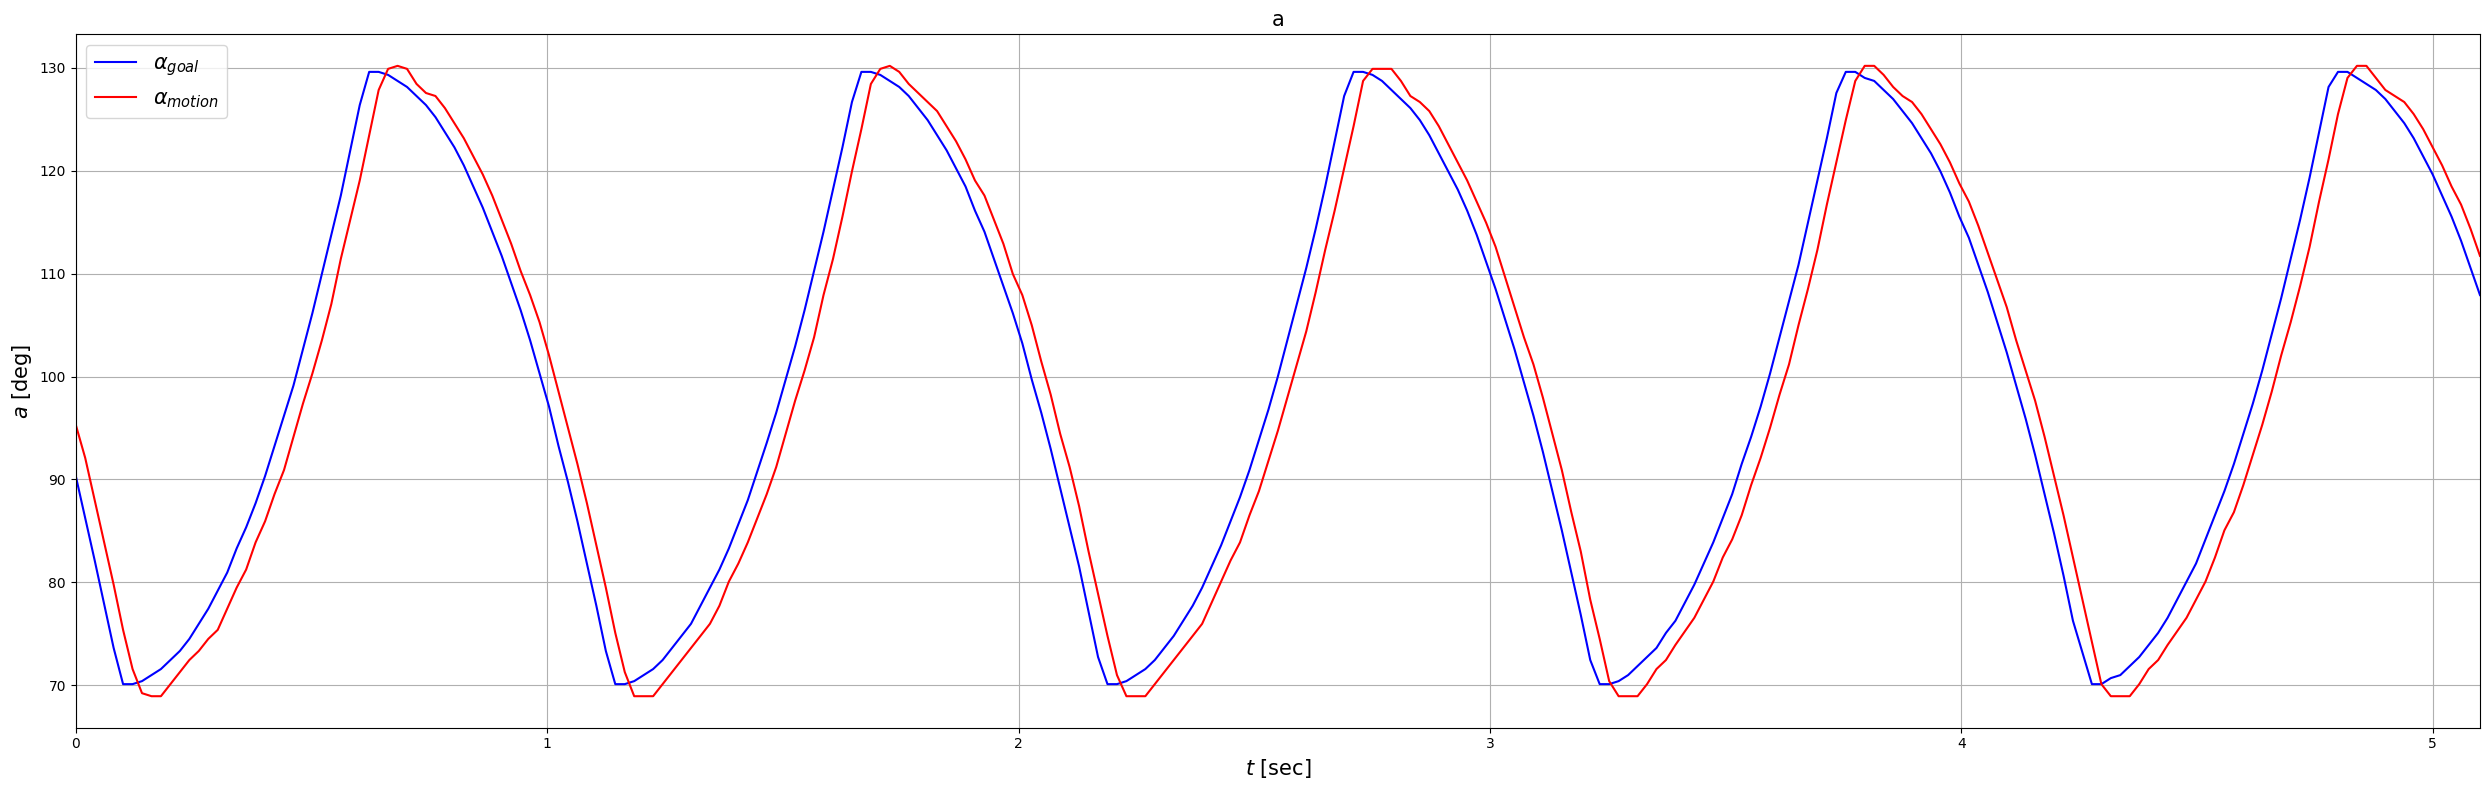

In [70]:
plt.figure(figsize = (25,8))
plt.plot(t,a,"-b",label="$\\alpha_{goal}$")
plt.plot(t,angle_motion,"-r",label="$\\alpha_{motion}$")
plt.title("a",fontsize=15)
plt.xlabel("$t$ [sec]",fontsize=15)
plt.ylabel("$a$ [deg]",fontsize=15)
plt.grid(True)
plt.xlim([0 ,t[-1]])
plt.legend( fontsize=15)
plt.tight_layout()
plt.show()

# plt.figure(figsize = (25,8))
# plt.plot(t,b,"-b",label="$\\alpha_{motion}$")
# plt.title("b",fontsize=15)
# plt.xlabel("$t$ [sec]",fontsize=15)
# plt.ylabel("$b$ [deg]",fontsize=15)
# plt.grid(True)
# plt.xlim([0 ,t[-1]])
# plt.legend( fontsize=15)
# plt.tight_layout()
# plt.show()

In [64]:
0.013056/4

0.003264

In [30]:
np.sqrt(2*(60*3.4099999999999997)/0.006528)

250.36737712691675

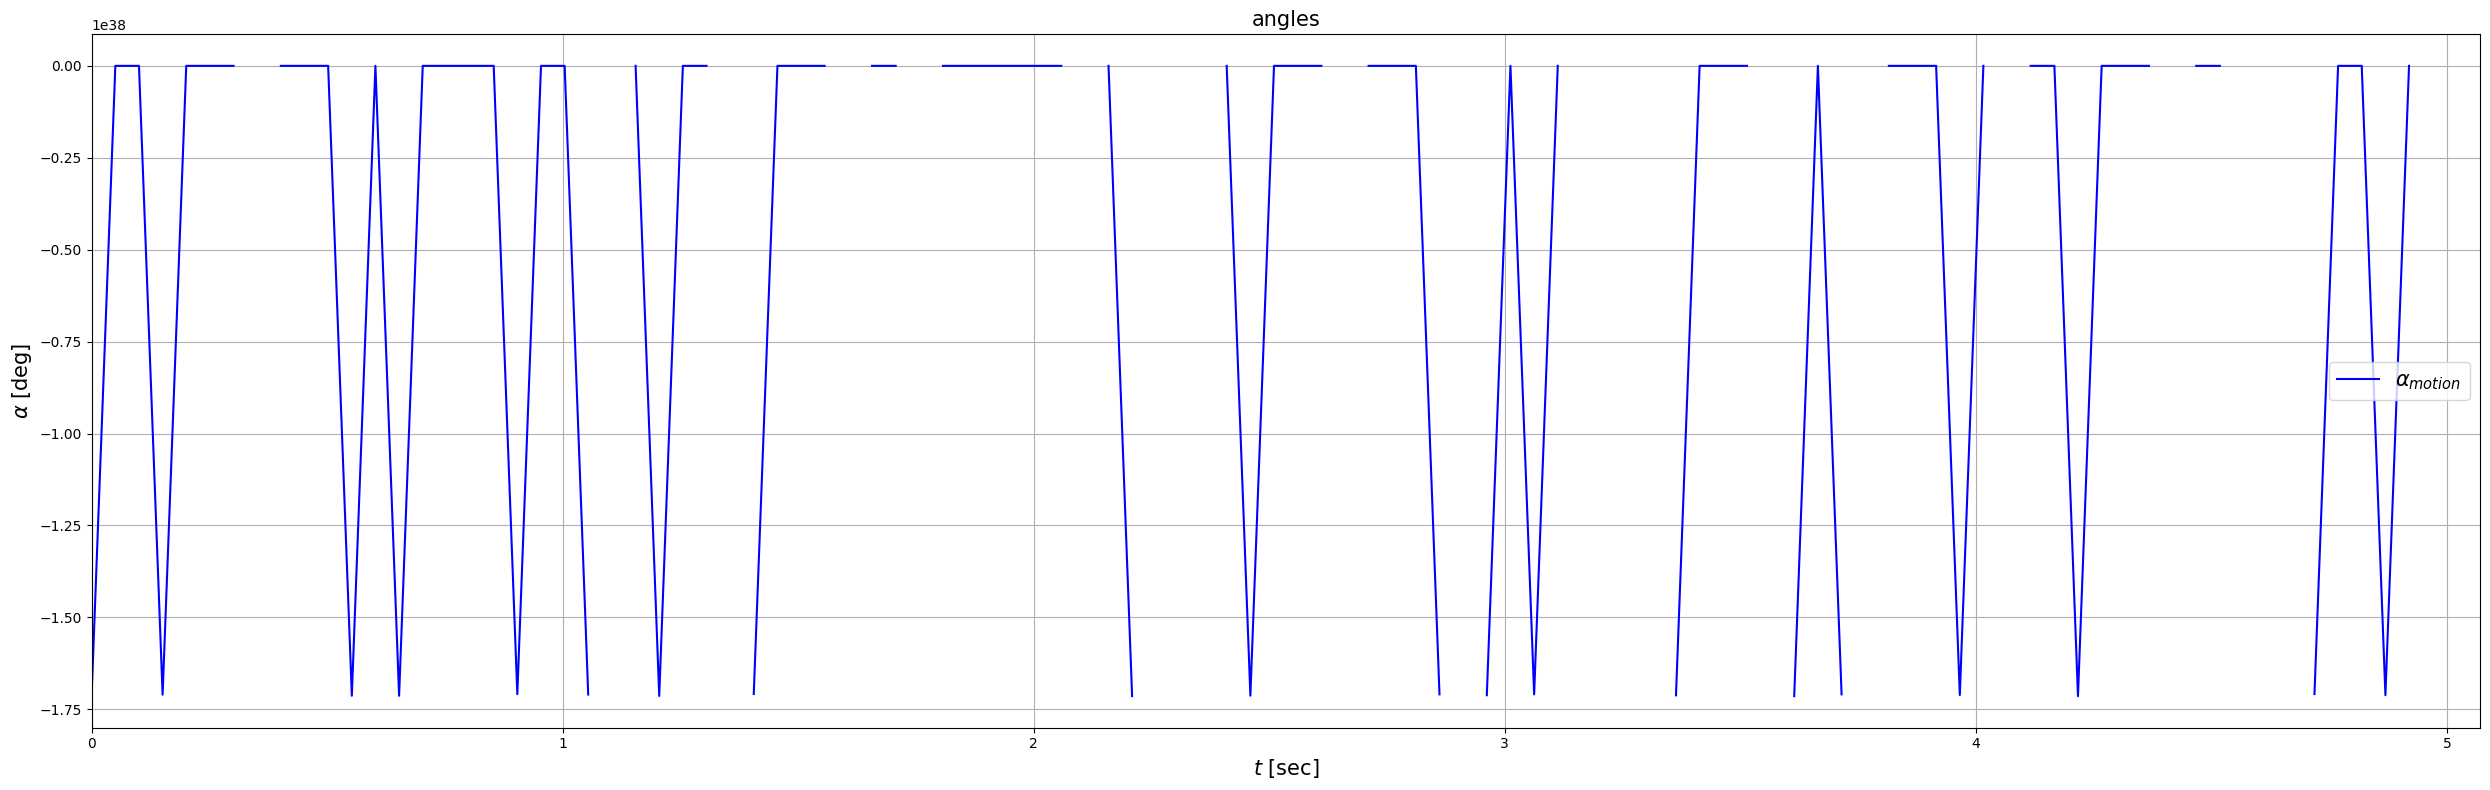

In [316]:
plt.figure(figsize = (25,8))
plt.plot(t,angle_motion,"-b",label="$\\alpha_{motion}$")
# plt.plot(t,angle_mode,"-r",label="$\\alpha_{mode}$")
plt.title("angles",fontsize=15)
plt.xlabel("$t$ [sec]",fontsize=15)
plt.ylabel("$\\alpha$ [deg]",fontsize=15)
plt.grid(True)
plt.xlim([0 ,t[-1]])
# plt.ylim([0,500])
plt.legend( fontsize=15)
plt.tight_layout()
plt.show()

In [302]:
3.4099999999999997*60

204.6

In [ ]:
# plt.subplots(2,1,figsize = (20,6))
# plt.subplot(211)

# plt.subplot(212)
# plt.plot(self.x_phi_true,self.y_phi_true)
# plt.axis('equal')
# plt.title("given beam shape (x,y)",fontsize=15)
# plt.xlabel("$x$ [mm]",fontsize=15)
# plt.ylabel("$y$ [mm]",fontsize=15)
# plt.grid(True)

In [280]:
ser.close()